# Predict Prices on laptops 
- Price is a target of prediction
- Brand, Processor Speed, RAM Size, Storage Capacity, Screen Size and Weight - the features

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import seaborn as sns
import numpy as np

# Reading Raw data from .csv file

In [2]:
raw_data = pd.read_csv('./data/Laptop_price.csv')
print(raw_data.shape)
raw_data.head(10)

(1000, 7)


,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718
5,HP,1.881348,16,256,11.943958,4.840268,9543.719980
6,Lenovo,2.940721,32,256,11.713246,4.344846,10390.137319
7,Lenovo,3.016788,4,256,15.588315,2.941120,9214.484506
8,Lenovo,2.560327,4,512,15.026332,2.743620,16372.175284
9,Acer,3.341111,32,512,13.611945,4.093149,18501.832733


## Configure Pipeline

In [3]:
from tpnn.features import Encoder

pipeline = (
    Encoder('Brand', strategy='codes') 
    >> Encoder('RAM_Size', strategy='codes') 
    >> Encoder('Storage_Capacity', strategy='codes') 
    >> Encoder(
        'Price', 
        strategy='bins', 
        bins=[0, 12500, 25000, float('+inf')],
    )
    >> Encoder(
        ['Processor_Speed', 'Screen_Size', 'Weight'], 
        strategy='quantiles', 
        quantiles=4,
    )
)

## Put raw data in preprocessing pipeline

In [4]:
pure_data = raw_data >> pipeline
pure_data

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,1,3,2,1,0,0,1
1,0,2,0,2,0,1,2
2,4,2,0,0,0,0,0
3,0,3,2,1,0,3,1
4,0,2,3,2,2,2,2
...,...,...,...,...,...,...,...
995,3,2,0,2,0,1,2
996,2,2,1,0,1,2,0
997,2,2,0,1,1,1,1
998,1,0,1,0,0,2,0


<Axes: >

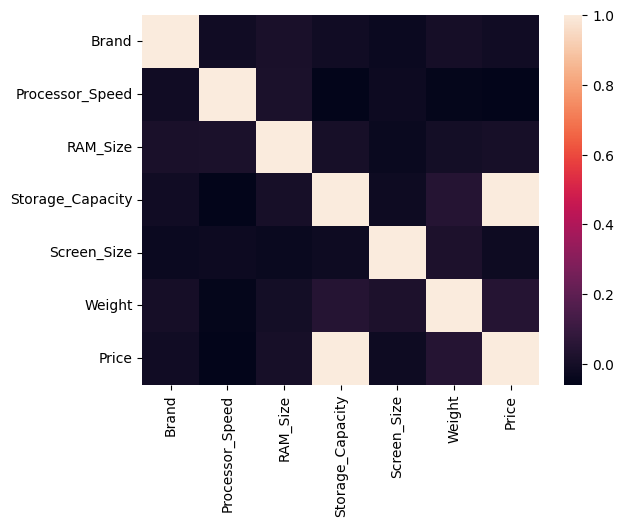

In [5]:
sns.heatmap(pure_data.corr())

## Find Gain Ratios for features

In [6]:
from tpnn.metrics import gain_ratio

# NOTE: `enumerate` and `i` here only for sorting purposes
ratios = [
    (gain_ratio(pure_data, column, 'Price'), i, column)
    for i, column in enumerate(pure_data.columns)
]

for ratio, _, column in sorted(ratios, reverse=True):
    print(f"Gain Ratio for {column}: {ratio:.4f}")

Gain Ratio for Price: 1.0000
Gain Ratio for Storage_Capacity: 1.0000
Gain Ratio for Processor_Speed: 0.0031
Gain Ratio for Brand: 0.0029
Gain Ratio for Weight: 0.0026
Gain Ratio for RAM_Size: 0.0023
Gain Ratio for Screen_Size: 0.0010


## Ranking for features with quantiles up to 10

In [7]:
from tpnn.metrics import gain_ratios

base_encoding = (
    Encoder('Brand', strategy='codes') 
    >> Encoder('RAM_Size', strategy='codes') 
    >> Encoder('Storage_Capacity', strategy='codes') 
    >> Encoder(
        'Price', 
        strategy='bins', 
        bins=[0, 12500, 25000, float('+inf')],
    )
)
for Q in range(2, 11):
    quantile_encoder = Encoder(
        ['Processor_Speed', 'Screen_Size', 'Weight'], 
        strategy='quantiles', 
        quantiles=Q,
    )
    encoded_data = raw_data >> base_encoding >> quantile_encoder
    print(f'{Q = }')
    print('='*39)
    for column, ratio in gain_ratios(encoded_data, 'Price'):
        print(f"Gain Ratio for {column}: {ratio:.4f}")
    print('='*39)
    


Q = 2
Gain Ratio for Price: 1.0000
Gain Ratio for Storage_Capacity: 1.0000
Gain Ratio for Brand: 0.0029
Gain Ratio for RAM_Size: 0.0023
Gain Ratio for Processor_Speed: 0.0009
Gain Ratio for Screen_Size: 0.0003
Gain Ratio for Weight: 0.0003
Q = 3
Gain Ratio for Price: 1.0000
Gain Ratio for Storage_Capacity: 1.0000
Gain Ratio for Weight: 0.0041
Gain Ratio for Brand: 0.0029
Gain Ratio for RAM_Size: 0.0023
Gain Ratio for Processor_Speed: 0.0020
Gain Ratio for Screen_Size: 0.0010
Q = 4
Gain Ratio for Price: 1.0000
Gain Ratio for Storage_Capacity: 1.0000
Gain Ratio for Processor_Speed: 0.0031
Gain Ratio for Brand: 0.0029
Gain Ratio for Weight: 0.0026
Gain Ratio for RAM_Size: 0.0023
Gain Ratio for Screen_Size: 0.0010
Q = 5
Gain Ratio for Price: 1.0000
Gain Ratio for Storage_Capacity: 1.0000
Gain Ratio for Screen_Size: 0.0031
Gain Ratio for Brand: 0.0029
Gain Ratio for Weight: 0.0023
Gain Ratio for RAM_Size: 0.0023
Gain Ratio for Processor_Speed: 0.0022
Q = 6
Gain Ratio for Price: 1.0000
Gain 